In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_openml
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

data= fetch_openml('mnist_784', version=1, parser='auto')  # data from https://www.openml.org/d/554
dfData = pd.DataFrame(np.c_[data["data"],
                      data["target"]],
                      columns = data["feature_names"] + ["target"])

In [4]:
img_pipeline = Pipeline([("mm_scaler", MinMaxScaler())])
y = dfData["target"]
dfData = dfData.drop("target",axis=1)
X = dfData.copy()
X_transf = img_pipeline.fit_transform(X)

In [5]:
stratSplit = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in stratSplit.split(X_transf, y):
    X_train = X_transf[train_index]
    X_test = X_transf[test_index]
    
    y_train = y[train_index]
    y_test = y[test_index]

In [6]:
log_reg = LogisticRegression(C=1e5, max_iter=100)
def performCV(log_reg, X_train, y_train):
    return cross_validate(log_reg,
                          X = X_train,
                          y = y_train,
                          scoring = "accuracy",
                          cv = 2,
                          n_jobs=-1,
                          verbose = False,
                          return_train_score=True,
                          return_estimator=True)
results = performCV(log_reg, X_train, y_train)

In [7]:
bestEstInd = np.argmax(results["test_score"])
best_estimator = results["estimator"][bestEstInd]
feature_importances_zero = best_estimator.coef_[0]

In [8]:
print(best_estimator.coef_.shape)
best_estimator.coef_

(10, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

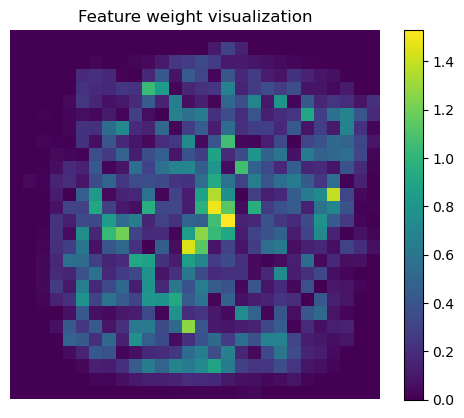

In [9]:
dfImp = pd.DataFrame({"feature":dfData.columns,
                     "weight":feature_importances_zero,
                     "weightAbs":np.absolute(feature_importances_zero)})

featureWeights = np.abs(dfImp["weight"].values)
# featureWeights[featureWeights<0.1]=0
plt.imshow(featureWeights.reshape(28,28))
plt.axis('off')
plt.colorbar()
plt.title("Feature weight visualization")
plt.show()

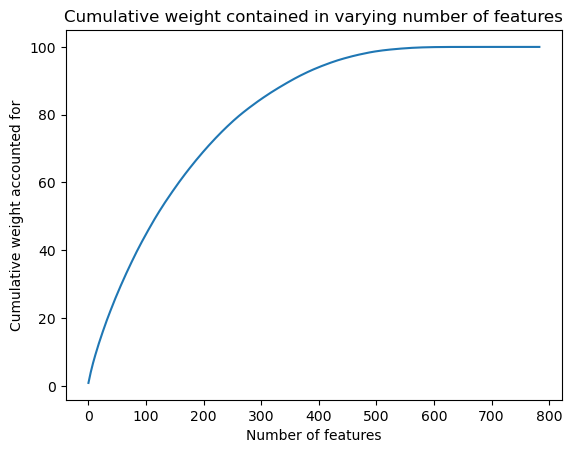

# feautres that contain 99% of weight: 513
Weight of next feature: -0.03801870086905191


In [10]:
dfImpCumImp = dfImp.sort_values("weightAbs", ascending=False).reset_index(drop=True)
dfImpCumImp["cumSumWeights"] = dfImpCumImp["weightAbs"].cumsum()
dfImpCumImp["cumSumPerc"] = 100*dfImpCumImp["weightAbs"].cumsum()/dfImpCumImp["cumSumWeights"].iloc[-1]
plt.plot(dfImpCumImp.index, dfImpCumImp["cumSumPerc"])
plt.title("Cumulative weight contained in varying number of features")
plt.xlabel("Number of features")
plt.ylabel("Cumulative weight accounted for")
plt.show()
xPercTotalWeightsInd = dfImpCumImp.loc[dfImpCumImp["cumSumPerc"]<99].index[-1]
print("# feautres that contain 99% of weight:", xPercTotalWeightsInd+1)
print("Weight of next feature:", dfImpCumImp.iloc[xPercTotalWeightsInd+1]["weight"])

In [11]:
dfImp.sort_values("weight", ascending=False, inplace=True)
print(dfImp.head())
print(dfImp.tail())

      feature    weight  weightAbs
360  pixel361  1.391599   1.391599
629  pixel630  1.271216   1.271216
428  pixel429  1.201536   1.201536
297  pixel298  1.066322   1.066322
240  pixel241  1.061972   1.061972
      feature    weight  weightAbs
434  pixel435 -1.262581   1.262581
351  pixel352 -1.346534   1.346534
461  pixel462 -1.449650   1.449650
379  pixel380 -1.488676   1.488676
408  pixel409 -1.529708   1.529708


In [12]:
sorted(zip(feature_importances_zero, dfData.columns), reverse=True)

[(1.391598950965442, 'pixel361'),
 (1.2712160839503341, 'pixel630'),
 (1.2015362411409307, 'pixel429'),
 (1.066321713803676, 'pixel298'),
 (1.0619724672546962, 'pixel241'),
 (1.0285538521957598, 'pixel123'),
 (1.0275170691251003, 'pixel428'),
 (0.9624739548414908, 'pixel383'),
 (0.9572532697595524, 'pixel375'),
 (0.9241855145070438, 'pixel573'),
 (0.9149458768700456, 'pixel191'),
 (0.9108038148118338, 'pixel371'),
 (0.9098235830330206, 'pixel486'),
 (0.8771548573352036, 'pixel487'),
 (0.8469164633124774, 'pixel400'),
 (0.8445890065162307, 'pixel124'),
 (0.8259658535704325, 'pixel343'),
 (0.8052654157670104, 'pixel571'),
 (0.7943967409306669, 'pixel271'),
 (0.7882601073396551, 'pixel543'),
 (0.785504692136984, 'pixel601'),
 (0.7816552238170055, 'pixel416'),
 (0.7810771635394195, 'pixel566'),
 (0.78091732636743, 'pixel572'),
 (0.7794539145150272, 'pixel515'),
 (0.7689552463742102, 'pixel654'),
 (0.7573684891220822, 'pixel426'),
 (0.7259047391716983, 'pixel360'),
 (0.7218473834398768, 'pi

In [13]:
impFeat = dfImp.loc[(dfImp["weight"]>0.04)|(dfImp["weight"]<-0.04)]["feature"]
impFeat

360    pixel361
629    pixel630
428    pixel429
297    pixel298
240    pixel241
         ...   
434    pixel435
351    pixel352
461    pixel462
379    pixel380
408    pixel409
Name: feature, Length: 511, dtype: object

In [14]:
X_transf_red = img_pipeline.fit_transform(X[impFeat])
for train_index, test_index in stratSplit.split(X_transf_red, y):
    X_train_red = X_transf_red[train_index]
    X_test_red = X_transf_red[test_index]
    
    y_train_red = y[train_index]
    y_test_red = y[test_index]

In [15]:
results_red = performCV(log_reg, X_train_red, y_train_red)

In [16]:
X_train_red.shape

(56000, 511)

In [21]:
def printCVPerformance(results, results_red):
    print("Number of features all:", results["estimator"][0].coef_.shape[1])
    print("Number of features reduced:", results_red["estimator"][0].coef_.shape[1])
    print("Test scores with all features:", round(np.mean(results["test_score"]), 4))
    print("Test scores with reduced feature set:", round(np.mean(results_red["test_score"]), 4))
    print("Average train time all features:", round(np.mean(results["fit_time"]), 2))
    print("Average train with reduced feature set:", round(np.mean(results_red["fit_time"]), 2))
printCVPerformance(results, results_red)

Number of features all: 784
Number of features reduced: 511
Test scores with all features: 0.8924
Test scores with reduced feature set: 0.8981
Average train time all features: 280.55
Average train with reduced feature set: 184.46


In [22]:
for max_iter in [100, 500, 1000]:
    log_reg = LogisticRegression(C=1e5, max_iter=max_iter)
    results = performCV(log_reg, X_train, y_train)
    results_red = performCV(log_reg, X_train_red, y_train_red)
    print("Performance for max_iter:", max_iter)
    printCVPerformance(results, results_red)
    print("\n")

Performance for max_iter: 100
Number of features all: 784
Number of features reduced: 511
Test scores with all features: 0.9123
Test scores with reduced feature set: 0.9124
Average train time all features: 31.03
Average train with reduced feature set: 17.95


Performance for max_iter: 500
Number of features all: 784
Number of features reduced: 511
Test scores with all features: 0.8975
Test scores with reduced feature set: 0.9014
Average train time all features: 135.96
Average train with reduced feature set: 89.96


Performance for max_iter: 1000
Number of features all: 784
Number of features reduced: 511
Test scores with all features: 0.8924
Test scores with reduced feature set: 0.8981
Average train time all features: 262.62
Average train with reduced feature set: 180.59


